🎯 Accuracy: 0.9988092718035563

📄 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17709
           1       1.00      1.00      1.00     20083

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



<ipython-input-2-fff33e0316ee>:72: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


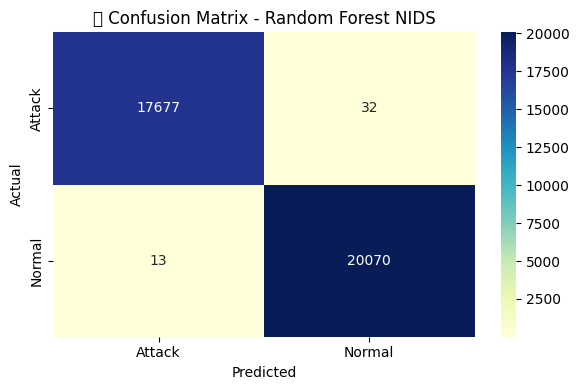

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Load dataset ===
df = pd.read_csv('KDDTrain+.txt', header=None)

# === Define column names (43 columns including 'difficulty_level') ===
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty_level'
]
df.columns = columns

# === Drop 'difficulty_level' (not useful for ML) ===
df.drop(['difficulty_level'], axis=1, inplace=True)

# === Convert labels to binary: 'normal' vs 'attack' ===
df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')

# === Encode categorical features ===
categorical_cols = ['protocol_type', 'service', 'flag']
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

# === Encode labels: 0 = attack, 1 = normal ===
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# === Split features and labels ===
X = df.drop(['label'], axis=1)
y = df['label']

# === Normalize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# === Train Random Forest Classifier ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# === Predict and Evaluate ===
y_pred = rf.predict(X_test)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Attack', 'Normal'],
            yticklabels=['Attack', 'Normal'])
plt.title('🧠 Confusion Matrix - Random Forest NIDS')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Feature Importance

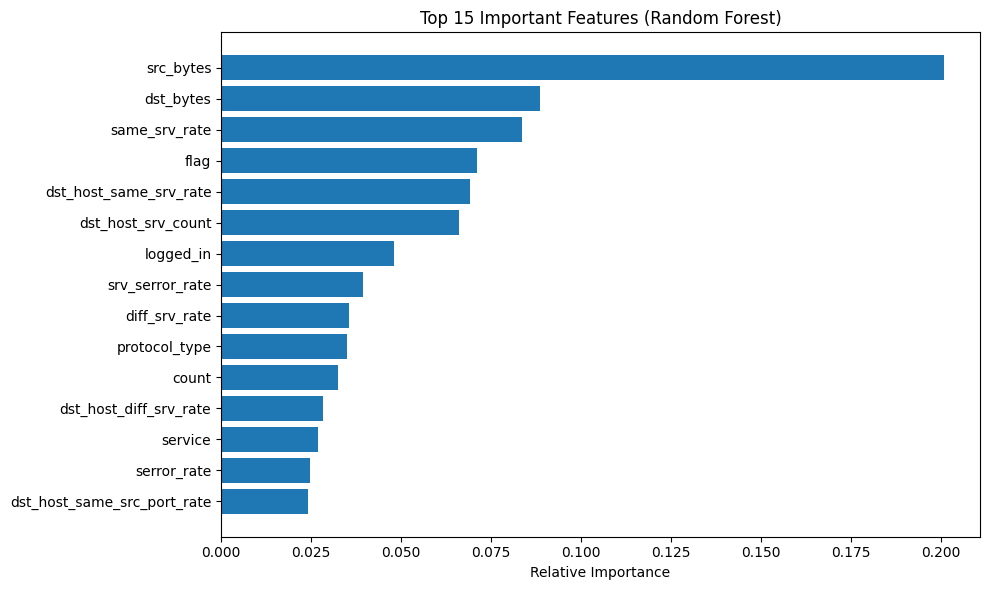

In [4]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Top 15 Important Features (Random Forest)")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()


Testing

In [8]:
!pip install gradio
import gradio as gr

def predict_intrusion(*inputs):
    input_array = np.array(inputs).reshape(1, -1)
    input_scaled = scaler.transform(input_array)
    prediction = rf.predict(input_scaled)[0]
    return 'Normal' if prediction == 1 else 'Attack'

feature_inputs = [gr.Number(label=col) for col in X.columns]

demo = gr.Interface(
    fn=predict_intrusion,
    inputs=feature_inputs,
    outputs=gr.Label(label="Prediction"),
    title="Random Forest NIDS",
    description="Enter feature values to detect network intrusion."
)

demo.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://133479bf713bba3afd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory

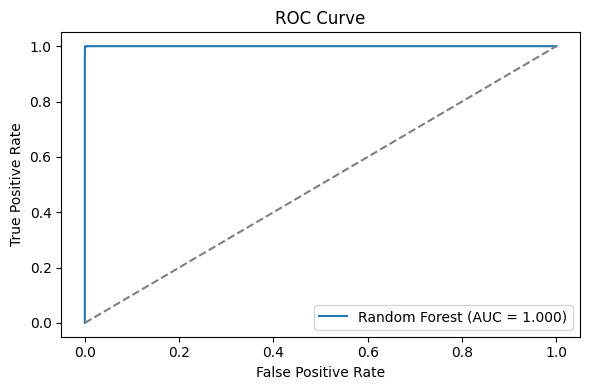

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.3f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()


✅ Accuracy: 0.9989283588013494

📄 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13422
           1       1.00      1.00      1.00     11773

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



<ipython-input-11-fc2a3a48995b>:74: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


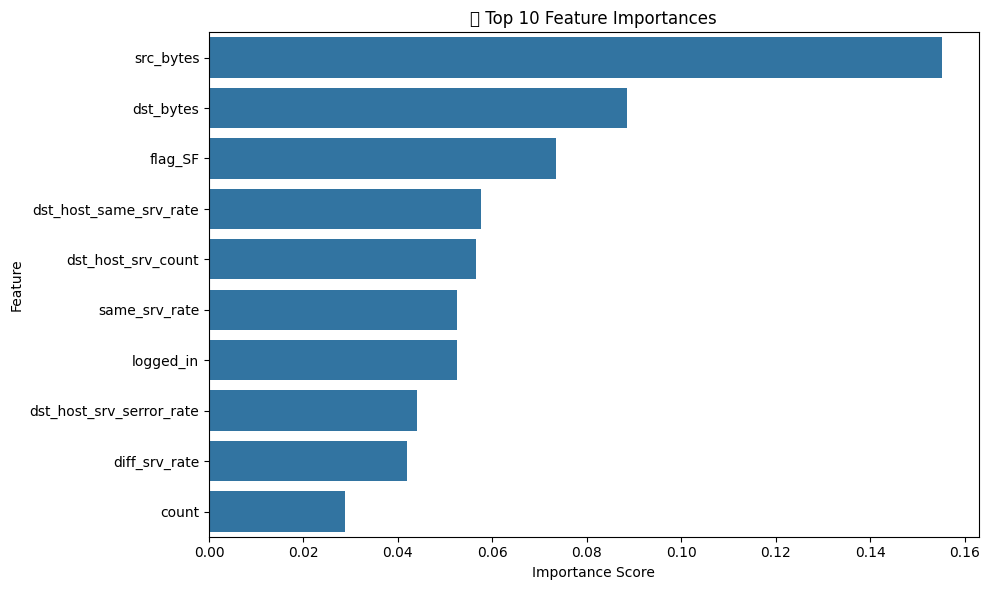

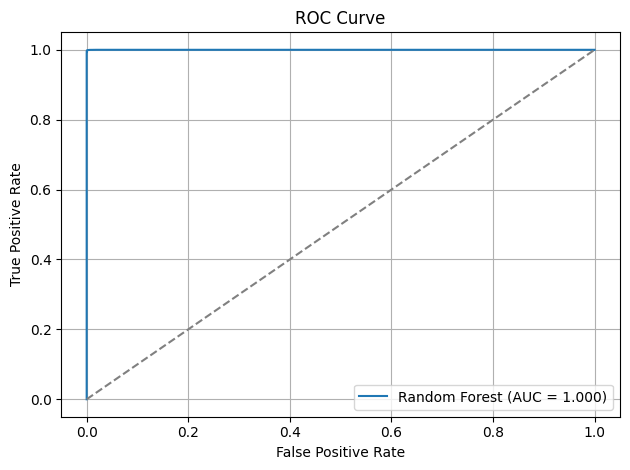

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9c214af8b57d0d182b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [11]:
# 📥 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import gradio as gr

# 📂 Load NSL-KDD dataset
df = pd.read_csv('KDDTrain+.txt', header=None)

# 🧱 Assign column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]
df.columns = columns

# ❌ Drop difficulty_level
df.drop(['difficulty_level'], axis=1, inplace=True)

# 🔃 Convert attack labels to binary (normal vs attack)
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# 🔡 Encode categorical columns
categorical_cols = ['protocol_type', 'service', 'flag']
df = pd.get_dummies(df, columns=categorical_cols)

# 🎯 Split features and target
X = df.drop(['label'], axis=1)
y = df['label']

# ⚖️ Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔀 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🌲 Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 📊 Predictions
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# 📈 Results
print(f"✅ Accuracy: {accuracy}")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))

# 🔍 Feature Importance
importances = model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[-10:][::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feat_names[indices])
plt.title("🔍 Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 🎯 ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 🚀 Gradio Web Interface for testing the model
def predict_intrusion(duration, protocol_type, service, flag, src_bytes, dst_bytes):
    input_data = pd.DataFrame([[duration, protocol_type, service, flag, src_bytes, dst_bytes]], columns=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes'])

    # Apply preprocessing (encode, scale, etc.)
    input_data = pd.get_dummies(input_data, columns=['protocol_type', 'service', 'flag'])
    input_data_scaled = scaler.transform(input_data)

    # Predict
    prediction = model.predict(input_data_scaled)
    if prediction == 0:
        return "Normal"
    else:
        return "Attack"

# Gradio UI
gr.Interface(fn=predict_intrusion,
             inputs=[gr.Slider(0, 100, label="Duration"), gr.Textbox(label="Protocol Type"), gr.Textbox(label="Service"),
                     gr.Textbox(label="Flag"), gr.Slider(0, 100000, label="Src Bytes"), gr.Slider(0, 100000, label="Dst Bytes")],
             outputs="text").launch()


In [12]:
import joblib

# Save the trained Random Forest model to a file
joblib.dump(rf, 'random_forest_nids_model.pkl')

print("Model saved successfully!")


Model saved successfully!


In [15]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# === Load dataset ===
df = pd.read_csv('KDDTrain+.txt', header=None)

# === Define column names (43 columns including 'difficulty_level') ===
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty_level'
]
df.columns = columns

# === Drop 'difficulty_level' (not useful for ML) ===
df.drop(['difficulty_level'], axis=1, inplace=True)

# === Convert labels to binary: 'normal' vs 'attack' ===
df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')

# === Encode categorical features ===
categorical_cols = ['protocol_type', 'service', 'flag']
encoders = {}

for col in categorical_cols:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])
    joblib.dump(encoders[col], f'{col}_encoder.pkl')  # Save each encoder

# === Encode labels: 0 = attack, 1 = normal ===
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# === Split features and labels ===
X = df.drop(['label'], axis=1)
y = df['label']

# === Normalize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Save the scaler ===
joblib.dump(scaler, 'scaler.pkl')

# === Train Random Forest Classifier ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# === Save the trained Random Forest model ===
joblib.dump(rf, 'random_forest_nids_model.pkl')


['random_forest_nids_model.pkl']

In [16]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# === Load the trained Random Forest model, scaler, and encoders ===
rf = joblib.load('random_forest_nids_model.pkl')
scaler = joblib.load('scaler.pkl')

# Load label encoders for categorical columns
encoders = {}
categorical_cols = ['protocol_type', 'service', 'flag']
for col in categorical_cols:
    encoders[col] = joblib.load(f'{col}_encoder.pkl')

# === Function for real-time prediction ===
def predict_real_time(data):
    # Check if columns are correct
    print(f"Data columns: {data.columns}")

    # Apply label encoding to categorical columns
    for col in categorical_cols:
        if col in data.columns:
            data[col] = encoders[col].transform(data[col])
        else:
            print(f"Column {col} is missing in the data.")

    # Normalize features
    X_scaled = scaler.transform(data)

    # Make prediction
    prediction = rf.predict(X_scaled)

    # Return the prediction (0 = attack, 1 = normal)
    return prediction

# === Example real-time data ===
# You would replace this with the actual real-time data you receive
sample_data = {
    'duration': [0],
    'protocol_type': ['tcp'],
    'service': ['http'],
    'flag': ['SF'],
    'src_bytes': [231],
    'dst_bytes': [0],
    'land': [0],
    'wrong_fragment': [0],
    'urgent': [0],
    'hot': [0],
    'num_failed_logins': [0],
    'logged_in': [1],
    'num_compromised': [0],
    'root_shell': [0],
    'su_attempted': [0],
    'num_root': [0],
    'num_file_creations': [0],
    'num_shells': [0],
    'num_access_files': [0],
    'num_outbound_cmds': [0],
    'is_host_login': [0],
    'is_guest_login': [0],
    'count': [0],
    'srv_count': [0],
    'serror_rate': [0],
    'srv_serror_rate': [0],
    'rerror_rate': [0],
    'srv_rerror_rate': [0],
    'same_srv_rate': [1],
    'diff_srv_rate': [0],
    'srv_diff_host_rate': [0],
    'dst_host_count': [0],
    'dst_host_srv_count': [0],
    'dst_host_same_srv_rate': [0],
    'dst_host_diff_srv_rate': [0],
    'dst_host_same_src_port_rate': [0],
    'dst_host_srv_diff_host_rate': [0],
    'dst_host_serror_rate': [0],
    'dst_host_srv_serror_rate': [0],
    'dst_host_rerror_rate': [0],
    'dst_host_srv_rerror_rate': [0]
}

# Convert the sample data to a DataFrame
df_sample = pd.DataFrame(sample_data)

# Predict the sample data
prediction = predict_real_time(df_sample)

# Output the result
if prediction[0] == 0:
    print("Prediction: Attack")
else:
    print("Prediction: Normal")


Data columns: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')
Prediction: Normal
